In [ ]:
!pip install yfinance

import yfinance as yf

In [ ]:
### import the currency data 

tikers=['GC=F', 'PL=F']
gold = yf.Ticker('GC=F')
data1 = gold.history(start='2018-2-25', end='2022-2-25')['Close']
data1=data1.to_numpy()[0:1008]
print(data1)


#platinum = yf.Ticker('PL=F')
#data2 = platinum.history(start='2018-2-25', end='2022-2-25')['Close']
#print(data2)


silver = yf.Ticker('SI=F')
data3 = silver.history(start='2018-2-25', end='2022-2-25')['Close']
data3 = data3.to_numpy()[0:1008]
print(data3)

dowjones = yf.Ticker('DIA')
data4 = dowjones.history(start='2018-2-25', end='2022-2-25')['Close']
data4.to_numpy()
data4 = data4.to_numpy()[0:1008]
print(data4)


Euro = yf.Ticker('EURUSD=X')
data5 = Euro.history(start='2018-2-25', end='2022-2-25')['Close']
data5.to_numpy()
data5 = data5.to_numpy()[0:1008]
print(data5)

yen = yf.Ticker('6J=F')
data6 = yen.history(start='2018-2-25', end='2022-2-25')['Close']
data6.to_numpy()
data6 = data6.to_numpy()[0:1008]
print(data6)

#yuan = yf.Ticker('RMBH22.CME')
#data7 = yuan.history(start='2018-2-25', end='2022-2-25')['Close']
#print(data7)



In [ ]:
from google.colab import files


uploaded1 = files.upload()

uploaded2 = files.upload()
import pandas as pd
import io
 
df = pd.read_csv(io.BytesIO(uploaded1['Yuan.csv']))
print(df)



In [ ]:
DF = pd.read_csv(io.BytesIO(uploaded2['platinum.csv']))
print(DF)

df1=df.loc[1008:1:-1,:]
df1=df1['Close/Last']
print(df1)
data7=df1.to_numpy()
data7.shape

df2=DF.loc[1008:1:-1,:]
df2=df2['Close/Last']
print(df2)
data2=df2.to_numpy()



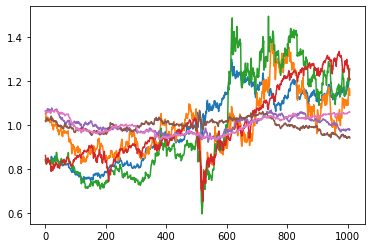

In [43]:
### construct V
import numpy as np
import matplotlib.pyplot as plt
data=[data1,data2,data3,data4,data5,data6,data7]
V=np.empty([1008,7])
MeanV=np.empty([1008,7])
for i in range(7):
  V[:,i] = data[i]
  mean=np.mean(data[i])
  MeanV[:,i]= data[i]/mean
  plt.plot(MeanV[:,i])

M=np.mean(V,axis=0)



In [174]:
### construct X,Z,rX,rZ
X=np.empty([1003,35])
Z=np.empty([1003,1])
for i in range(4,1007):
  Z[i-4]=V[i+1,0]
  x=V[i,:]
  for j in range(1,5):
    x=np.append(x,V[i-j,:])
  X[i-4,:]=x

rX=np.empty([1002,35])
rZ=np.empty([1002,1])
for i in range(1,1002):
  rX[i,:]=(X[i+1,:]-X[i,:])/X[i,:]
  rZ[i,:]=(Z[i+1,:]-Z[i,:])/Z[i,:]


mrZ=np.mean(np.absolute(rZ))





In [241]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rX, rZ, test_size=0.2, random_state=42)
# Set the input shape
input_shape = (35,)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
#h=22
model = Sequential()
model.add(Dense(22, input_shape=input_shape, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

optimizer= tf.keras.optimizers.Adam(learning_rate=0.0002)
# Instantiate a loss function.
loss = tf.keras.losses.MeanSquaredError()

batch_size=40

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=3000).batch(batch_size)


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 22)                792       
                                                                 
 dense_109 (Dense)           (None, 1)                 23        
                                                                 
Total params: 815
Trainable params: 815
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_train.shape

(801, 35)

In [ ]:
def GradNorm(grads):
  w=grads[0].numpy()
  w=w.flatten()
  for i in range(1,4):
    w1=grads[i].numpy()
    w=np.append(w, w1.flatten())

  return np.linalg.norm(w)

import time
import math 
    
epochs = 200
h=5
trainMSE=[]
testMSE=[]
NormGrad=[]
trainacc=[]
testacc=[]
time1=time.time()
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=3000).batch(batch_size)
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)
              # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss(y_batch_train, logits)
            #print(loss_value.numpy())
            
            
            



        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
        #NormGrad.append(GradNorm(grads))
        

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        #Weight=model.getweights()

# Log every 200 batches.
        if step % 5 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
        if step == 20:
          ###compute the trainMSE, testMSE, trainACC, testACC, ||grad|| at the end od every epoch
          NormGrad.append(GradNorm(grads)/math.sqrt(815))
          logits1 = model(X_train, training=False)
          logits2 = model(X_test, training=False)
          loss_value = loss(y_train, logits1)
          trainMSE.append(loss_value.numpy())
          trainacc.append(math.sqrt(loss_value.numpy())/mrZ)
          loss_value2 = loss(y_test, logits2)
          testMSE.append(loss_value2.numpy())
          testacc.append(math.sqrt(loss_value2.numpy())/mrZ)

   
    

time2=time.time()


In [ ]:
plt.plot(trainMSE)
plt.plot(testMSE)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(trainacc)
plt.plot(testacc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(NormGrad)
plt.ylabel('||grad||/sqrt(para(h))')




In [ ]:

Weight=model.weights
Weight12=Weight[0].numpy()
Weight23=Weight[2].numpy()
weight12=np.reshape(np.absolute(Weight12),770)
# display the histogram of weights linking the first layer and the second layer
plt.hist(weight12)
plt.show()
# display the weights linking the second layer to the third layer
m=np.sort(np.absolute(Weight23),axis=None)
plt.plot(m)
plt.show()
print(m)

In [ ]:
i =  np.argmax(np.absolute(Weight23))
# i is the i* which is the index of the most influencial neuron in the hidden layer
w = np.absolute(Weight12[:,i])
w.shape
mean_input = np.mean(np.absolute(rX),axis=0)
impact = np.multiply(w,mean_input)
## compute the impact of the j neuron of the first layer on the i* neuron of the hidden layer
impact
plt.plot(np.sort(impact))
index = np.argsort(impact)
### sort impact and get the index of the sorted impact to identify the important features
index

In [232]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, svd_solver='full')
X=pca.fit_transform(rX,)
X.shape

## perform the pca analysis on rX to select the size of the hidden layer of the MLP


(1002, 1)